# Initial Set Up

## Importing Libraries

### Data Libraries

In [1]:
import pandas as pd

### Modeling Libraries

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### Plotting

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

### Tracking Libraries

In [4]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow_experiment_id = 260523122208174751

### Helper Functions

In [5]:
from helper import split_into_lemmas
from helper import TfidfVectorizer

# Reading All Data

In [7]:
train = pd.read_csv('Data/train.csv',
                       header=0)
train = train.dropna()
msg_train = train['content']
label_train = train['label']

tfidf = TfidfVectorizer(data=msg_train)

tfidf_train = tfidf.tfidf_vector(msg_train)

ValueError: Expected 2D array, got scalar array instead:
array=CountVectorizer(analyzer=<function split_into_lemmas at 0x176164c20>).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
test = pd.read_csv('Data/test.csv', header=0)
test = test.dropna()
msg_test = test['content']
label_test = test['label']

tfidf_test = tfidf.tfidf_vector(msg_test)

In [ ]:
val = pd.read_csv('Data/validation.csv', header=0)
val = val.dropna()
msg_val = val['content']
label_val = val['label']

tfidf_val = tfidf.tfidf_vector(msg_val)

# Model Selection

- I choose to train a Support Vector Classifier.
- I start by creating a pipeline and auto-tune over the training data to find the ideal hyper-parameters.

## Run Grid Search on Potential Values of Hyper Parameters

In [ ]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(
        analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__kernel': ['linear']
   },
  {'classifier__C': [1, 10, 100, 1000],
   'classifier__gamma': [0.001, 0.0001],
   'classifier__kernel': ['rbf']
   },
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=10),  # what type of cross validation to use
)

svm_detectors = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm

## Log All Values into ML Flow

In [ ]:
gscv_mean_acc = svm_detectors.cv_results_['mean_test_score']
gscv_std_acc = svm_detectors.cv_results_['std_test_score']
gscv_params = svm_detectors.cv_results_['params']

For each of the potential models, we need to store the AUC-PR score on the **Test** data.
Thus the following things are stored in ML Flow:
- Parameters
    - `kernel`
    - `C`
    - `gamma` (only if `kernel` is 'rbf')
- Metrics
    - *Accuracy (Mean)* : Mean accuracy on the Training Data
    - *Accuracy (StD)* : Mean accuracy on the Training Data
    - *AUC-PR* : AUC-PR of the model on the Testing Data

In [ ]:
for i in range(len(gscv_params)):
# for i in range(1):
    run_mean_acc = gscv_mean_acc[i]
    run_std_acc = gscv_std_acc[i]
    run_params = gscv_params[i]
    run_params = {key[len("classifier__"):] : run_params[key]
                  for key in run_params.keys()}
    
    print(run_params)
    with mlflow.start_run(experiment_id=mlflow_experiment_id):
        svc = SVC(probability=True,
                  **run_params)\
                .fit(tfidf_train, label_train)
        
        # Log Parameters
        for param, value in run_params.items():
            mlflow.log_param(param, value)
            
        # Log Metrics
        mlflow.log_metric("Accuracy-Mean", run_mean_acc)
        mlflow.log_metric("Accuracy-StD", run_std_acc)
        
        y_score = svc.predict_proba(tfidf_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_true=label_test,
                                                               probas_pred=y_score,
                                                               pos_label='spam')
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        mlflow.log_metric("AUC-PR", auc_precision_recall)
        
        # Log Model
        mlflow.sklearn.log_model(
            sk_model=svc,
            artifact_path=f'skl-svc-{run_params["kernel"]}',
            registered_model_name=f'skl-svc-{run_params["kernel"]}')

{'C': 1, 'kernel': 'linear'}
{'C': 10, 'kernel': 'linear'}
{'C': 100, 'kernel': 'linear'}
{'C': 1000, 'kernel': 'linear'}
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


# Implementing the Final Model

Now, the SVC with the following hyper-parameter has the highest AUC-PR:
- `C` $= 1$
- `kernel` : 'linear'

I proceed to train an SVC with these hyper-parameter values so that it can be used for making predications.

## Training

In [ ]:
spam_detector = SVC(kernel='linear',
                    C=1,
                    probability=True)\
                .fit(tfidf_train, label_train)

### Evaluation on Training Data

In [ ]:
pred_train = spam_detector.predict(tfidf_train)
print(f'Accuracy on Training Data: {accuracy_score(label_train, pred_train) * 100:.2f} %')

Accuracy on Training Data: 100.00 %


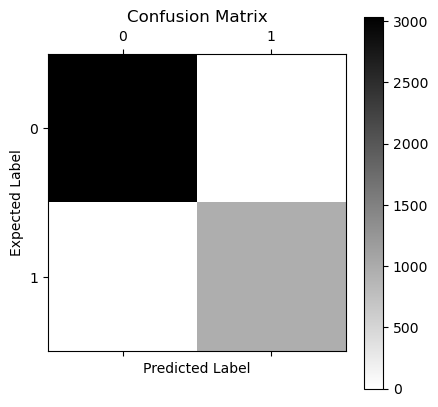

In [ ]:
plt.matshow(confusion_matrix(label_train, pred_train),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(label_train, pred_train))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3037
        spam       1.00      1.00      1.00       971

    accuracy                           1.00      4008
   macro avg       1.00      1.00      1.00      4008
weighted avg       1.00      1.00      1.00      4008



## Evaluation on Testing Data

In [ ]:
pred_test = spam_detector.predict(tfidf_test)
print(f'Accuracy on Testing Data: {int(10000 * accuracy_score(label_test, pred_test)) / 100} %')

Accuracy on Testing Data: 99.03 %


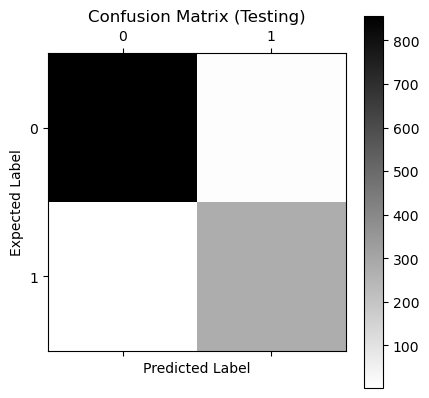

In [ ]:
plt.matshow(confusion_matrix(label_test, pred_test),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(label_test, pred_test))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       865
        spam       0.97      0.99      0.98       279

    accuracy                           0.99      1144
   macro avg       0.98      0.99      0.99      1144
weighted avg       0.99      0.99      0.99      1144



## Evaluation on Validation Data

In [ ]:
pred_val = spam_detector.predict(tfidf_val)
print(f'Accuracy on Testing Data: {int(10000 * accuracy_score(label_val, pred_val)) / 100} %')

Accuracy on Testing Data: 99.47 %


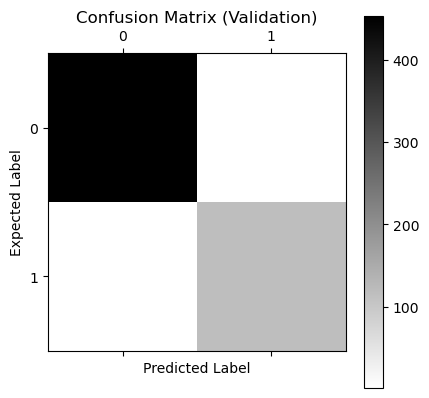

In [ ]:
plt.matshow(confusion_matrix(label_val, pred_val),
            cmap=plt.cm.binary,
            interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.colorbar()
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(label_val, pred_val))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       455
        spam       0.98      0.99      0.99       117

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572

